Plot the MAE for individual items.

In [1]:
import sys
sys.path.append('..')

import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import eval_reallabor_utils
import utils
import custom_rcparams as crc

main_dir = utils.join_base_path('bptt/results/MRT1_EveryDay02_Smoothed_best_runs')
eval_dir = '00_summary_gridsearch'
metric = 'mae'
sources_of_variance = ['participant']
save_as = None
include_hyper = {}
exclude_hyper = {
                    'feature': ['EMA_emotion_control', 'EMA_emotion_change']
                    # 'participant': [38, 42]
                }

color_version = 'construct'
sort_by = ['mae']

eval_dir = os.path.join(main_dir, eval_dir)
results = pd.read_csv(os.path.join(eval_dir, 'evaluation.csv'), index_col=0)
results = eval_reallabor_utils.include_exclude_hypers(results, include_hyper, exclude_hyper)
results_dir = os.path.join(eval_dir, 'item_predictability')
os.makedirs(results_dir, exist_ok=True)

d:\ZI Mannheim\KI Reallabor\bptt\.venv\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


TypeError: 'NoneType' object is not subscriptable

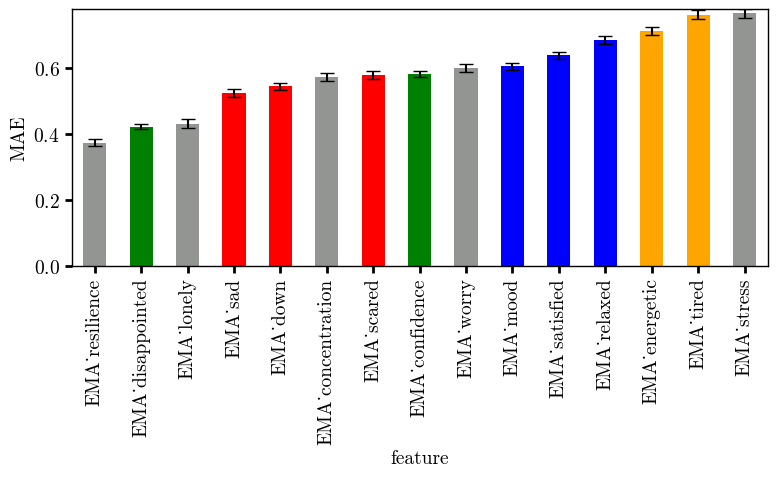

In [2]:
metrics, errorbars = eval_reallabor_utils.calculate_metrics(
    results, ['feature'], [metric], sources_of_variance=sources_of_variance)
metrics.sort_values(by=metric, inplace=True)
errorbars.sort_values(by=metric, inplace=True)
m_unstacked = metrics.unstack()[metric]
e_unstacked = errorbars.unstack()[metric]
fig, ax = plt.subplots()
T = range(1, len(m_unstacked)+1)
color = crc.colors.item_color_codes(m_unstacked.index, version=color_version)
m_unstacked.plot(ax=ax, yerr=e_unstacked, kind='bar', color=color, ylabel='MAE')

fig.tight_layout()
plt.savefig(os.path.join(results_dir, 'mean_over_participants.png'))

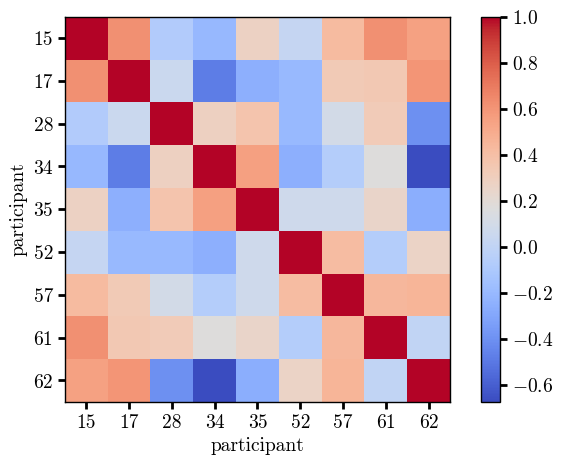

In [3]:
mae, errorbars = eval_reallabor_utils.calculate_metrics(results, ['participant', 'feature'], [metric])
mae = mae.dropna()
mae_per_participant = mae.unstack('participant')
mae_per_participant = mae_per_participant.dropna(axis=1).sort_index(axis=1)
participant_correlation = mae_per_participant.corr()
participants = mae_per_participant.columns.get_level_values(1)

plt.figure(figsize=(len(participants)*0.33,len(participants)*0.33))
plt.imshow(participant_correlation, origin='upper', aspect='equal', cmap='coolwarm')
plt.xticks(range(len(participant_correlation)), participants, rotation=90)
plt.yticks(range(len(participant_correlation)), participants)
plt.xlabel('participant')
plt.ylabel('participant')
plt.grid(False)
plt.colorbar()
plt.savefig(os.path.join(results_dir, 'correlation_over_participants.png'))

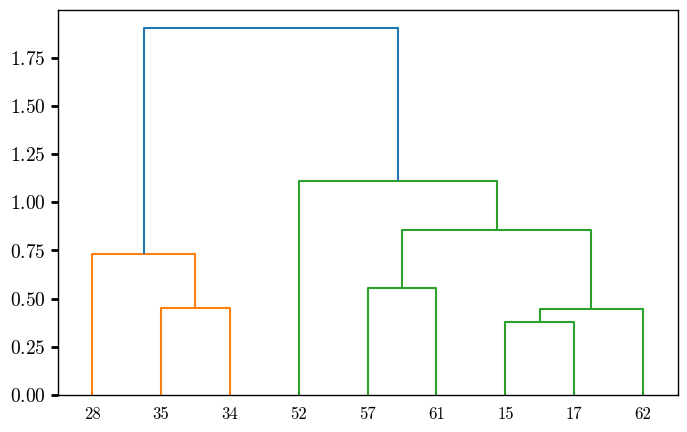

In [4]:
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster
from scipy.spatial.distance import squareform, pdist

y = squareform(1 - participant_correlation.to_numpy())
Z = linkage(y, method='ward', optimal_ordering=False)
R = dendrogram(Z, labels=participants)
plt.savefig(os.path.join(results_dir, 'cluster_dendrogram.png'))

[28, 34, 35]
[15, 17, 52, 57, 61, 62]


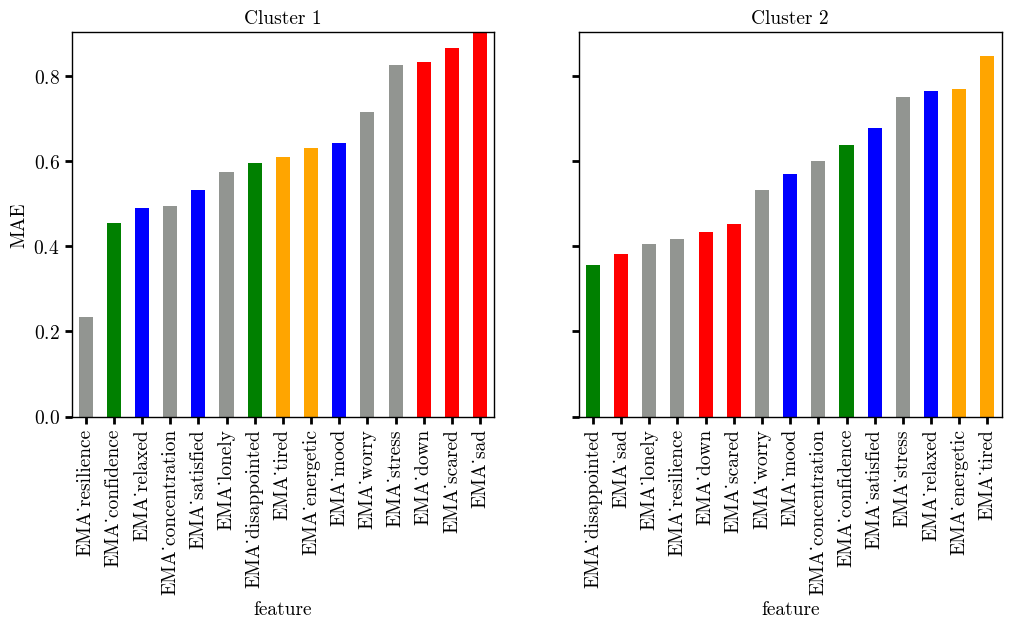

In [5]:
import custom_rcparams as crc

n_clusters = len(set(R['color_list'])) - 1
clusters = fcluster(Z, n_clusters, 'maxclust')
assign_to_cluster = {p: clust for p, clust in zip(participants, clusters)}
# clusters = fcluster(Z, (Z[:,2]-(1e-4)).sort()[n_clusters - 1], 'distance')

fig, axes = plt.subplots(1, n_clusters, figsize=(1+4.5*n_clusters,3), sharey=True)
for k, clust in enumerate(range(1, n_clusters+1)):
    mae_cluster = mae.unstack().loc[clusters==clust, metric].mean(axis=0).sort_values()
    color = crc.colors.item_color_codes(mae_cluster.index, version=color_version)
    mae_cluster.plot(ax=axes[k], kind='bar', color=color, ylabel='MAE',
                    title=f'Cluster {clust}')
    print(sorted(participants[clusters==clust]))
axes[-1].legend(*crc.colors.construct_legend_handles_labels('positive affect', 'negative affect', 'self-esteem', 'activity level'),
                    loc='center left', bbox_to_anchor=(1., 0.5))
plt.savefig(os.path.join(results_dir, 'mean_over_clustered_participants.png'))

/tmp/ipykernel_2938185/2700892664.py:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  train_vars = results.groupby(['participant','feature']).mean()


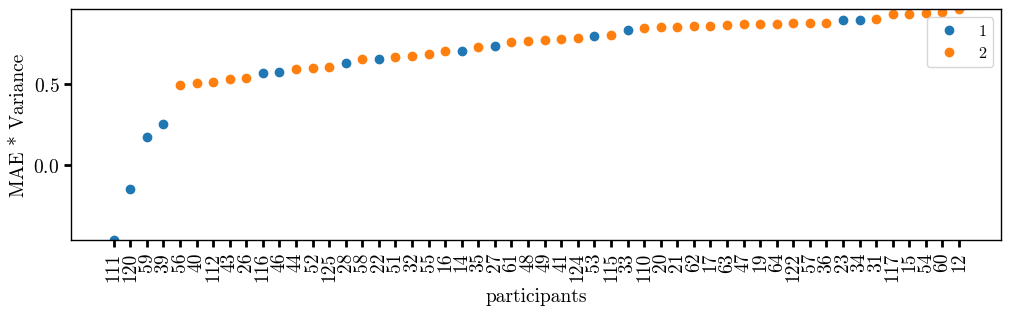

In [49]:
train_vars = results.groupby(['participant','feature']).mean() 
train_vars['mae'] = mae
mae_var_correls = np.zeros(len(participants))
for i, p in enumerate(participants):
    mae_var_correls[i] = train_vars.loc[train_vars.index.get_level_values('participant')==p, ['train_var', 'mae']].corr().to_numpy()[0,1]
plt.subplots(figsize=(12,3))
order = mae_var_correls.argsort()
unique_clusters = np.unique(clusters)
for c in unique_clusters:
    plt.plot(np.arange(len(order))[clusters[order]==c], mae_var_correls[order][clusters[order]==c], 
             marker='o', linestyle='')
plt.xticks(range(len(participants)), participants[order], rotation=90)
plt.xlabel('participants')
plt.ylabel('MAE * Variance')
plt.legend(unique_clusters)
plt.savefig(os.path.join(results_dir, 'correlation predictability variance.png'))

In [ ]:
from intervention_effects_utils import EffectsPrediction
import data_utils
ema_names = ['EMA_mood','EMA_disappointed','EMA_scared','EMA_worry',
    'EMA_down','EMA_sad','EMA_confidence','EMA_stress','EMA_lonely',
    'EMA_energetic','EMA_concentration','EMA_resilience','EMA_tired',
    'EMA_satisfied', 'EMA_relaxed']

raw_data_dir = data_utils.join_base_path('reallaborai4u/data_management/processed_csv_no_con')

E = EffectsPrediction(raw_data_dir, main_dir, model_for_prediction='current', try_to_load_predictions_file=True)

gt_effects = E.calc_effects(use_predicted=False, EMI_only=True)
pred_effects = E.calc_effects(use_predicted=True, EMI_only=True)

pred_effects['MAE'] = (pred_effects - gt_effects).abs()[ema_names].mean(axis=1)
pred_effects = pred_effects[pred_effects['model_id'].notna()]
pred_effects = pred_effects.groupby(['participant']).mean(numeric_only=True)
pred_effects['cluster'] = assign_to_cluster

mean_cluster_effects = pred_effects.groupby('cluster')['MAE'].mean(numeric_only=True)
sem_cluster_effects = pred_effects.groupby('cluster')['MAE'].sem(numeric_only=True)
ax = mean_cluster_effects.plot(kind='bar', yerr=sem_cluster_effects, 
                          color=crc.colors.color_cycle[1:],
                          figsize=[4,4])
ax.set(ylim=(0, ax.get_ylim()[1]*1.05),
       title='Effects prediction error',
       yticks=[0, 0.5, 1])
ax.set_xticks([0,1], labels=[1,2], rotation=0)